### Financial Index Prediction
This notebook seeks to predict the direction of a financial index from day k-1 to day k given financial news headlines from day k. A range of different combinations between statistical and NLP-models are used.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm, trange
from sentence_transformers import SentenceTransformer
from sklearn.utils import parallel_backend
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.base import ClassifierMixin, BaseEstimator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Embedding, Masking, Lambda, Layer, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import os
import itertools

#### Load financial news data and financial index data

In [2]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
fin_data = fin_data.loc['2006-10-19' : '2013-11-22']

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

In [3]:
news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)
        
# Create targets for all 3 time series 
targets = pd.DataFrame(dtype='int8')
prev_vals = fin_data.iloc[0]
for i in range(len(valid_dates)): 
    y_temp = []
    # If the value has increased since yesterday, y = 1
    if prev_vals['1 YEAR'] < fin_data.iloc[i+1]['1 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['3 YEAR'] < fin_data.iloc[i+1]['3 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['S&P'] < fin_data.iloc[i+1]['S&P']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
    targets = targets.append({'1 YEAR':y_temp[0], '3 YEAR':y_temp[1], 'S&P':y_temp[2]}, ignore_index=True)
    prev_vals = fin_data.iloc[i+1]

In [4]:
# Concatenate the news for each day in the valid indices, i.e. the indices that are present in both 
# the financial data and the news data 
texts = []
for ind,date in enumerate(tqdm(valid_dates)): 
    temp_texts = ""
    for i,text in enumerate(news_data.loc[date]['title']): 
        if i < len(news_data.loc[date]['title']) - 1:
            temp_texts += text + ". "
        else:
            temp_texts += text + "."
    texts.append(temp_texts)
texts = np.asarray(texts)
print("Length of texts:",len(texts))
print("Length of targets:",len(targets))

100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [07:22<00:00,  4.18it/s]


Length of texts: 1846
Length of targets: 1846


#### Format the data with SBERT


In [5]:
# Load a pre-trained SBERT-model 
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [6]:
path = ONEDRIVE_PATH / "Input Data/news_embedded_today_bert_base_nli_mean.npy"
# Check if an embedding matrix for the news dataset has been previously constructed 
if os.path.exists(path):
    x = np.load(path)
    embed_dim = x.shape[-1]
    print("Loaded previously saved embeddings.")
else:
    # Create embedding matrix for every sample with the mean embedding over all sentences in that review
    x = np.zeros((len(targets), 768))
    for i,text in enumerate(tqdm(texts)):
        sbert_texts = sbert_model.encode(sent_tokenize(text))
        x[i] = np.mean(sbert_texts,axis=0)
    np.save(path,x)

Loaded previously saved embeddings.


#### Partition into training and test set
Since the data is somewhat imbalanced - mostly for the 1 year rate - the training data will be under sampled by the minority class. 

In [7]:
zero_indices_1yr = np.where(targets['1 YEAR'] == 0)[0]
one_indices_1yr = np.where(targets['1 YEAR'] == 1)[0]

zero_indices_3yr = np.where(targets['3 YEAR'] == 0)[0]
one_indices_3yr = np.where(targets['3 YEAR'] == 1)[0]

zero_indices_sp = np.where(targets['S&P'] == 0)[0]
one_indices_sp = np.where(targets['S&P'] == 1)[0]

print(" ----- 1 YEAR RATE -----")
print("Ratio neg labels 1 year rate:",len(zero_indices_1yr) / len(targets))
print("Neg labels:", len(zero_indices_1yr), "Pos labels:",len(one_indices_1yr))
print(" ----- 3 YEAR RATE -----")
print("Ratio neg labels 3 year rate:",len(zero_indices_3yr) / len(targets))
print("Neg labels:", len(zero_indices_3yr), "Pos labels:",len(one_indices_3yr))
print(" -----     S&P     -----")
print("Ratio neg labels S&P:",len(zero_indices_sp) / len(targets))
print("Neg labels:", len(zero_indices_sp), "Pos labels:",len(one_indices_sp))

 ----- 1 YEAR RATE -----
Ratio neg labels 1 year rate: 0.6890574214517876
Neg labels: 1272 Pos labels: 574
 ----- 3 YEAR RATE -----
Ratio neg labels 3 year rate: 0.5937161430119177
Neg labels: 1096 Pos labels: 750
 -----     S&P     -----
Ratio neg labels S&P: 0.4637053087757313
Neg labels: 856 Pos labels: 990


In [8]:
n_train = 1200
n = len(targets)

np.random.shuffle(zero_indices_1yr)
np.random.shuffle(one_indices_1yr)
part_zeros_1yr = len(zero_indices_1yr) / n
train_indices_1yr = np.zeros((n_train),dtype=int)
train_indices_1yr[:round(part_zeros_1yr * n_train)] = zero_indices_1yr[:round(part_zeros_1yr * n_train)]
train_indices_1yr[round(part_zeros_1yr * n_train):] = one_indices_1yr[:round((1 - part_zeros_1yr) * n_train)]
np.random.shuffle(train_indices_1yr)
# All indices not in train is in test. 
test_indices_1yr = np.setdiff1d(np.arange(len(targets)), train_indices_1yr)
np.random.shuffle(test_indices_1yr)

np.random.shuffle(zero_indices_3yr)
np.random.shuffle(one_indices_3yr)
part_zeros_3yr = len(zero_indices_3yr) / n
train_indices_3yr = np.zeros((n_train),dtype=int)
train_indices_3yr[:round(part_zeros_3yr * n_train)] = zero_indices_3yr[:round(part_zeros_3yr * n_train)]
train_indices_3yr[round(part_zeros_3yr * n_train):] = one_indices_3yr[:round((1 - part_zeros_3yr) * n_train)]
np.random.shuffle(train_indices_3yr)
# All indices not in train is in test. 
test_indices_3yr = np.setdiff1d(np.arange(len(targets)), train_indices_3yr)
np.random.shuffle(test_indices_3yr)

np.random.shuffle(zero_indices_sp)
np.random.shuffle(one_indices_sp)
part_zeros_sp = len(zero_indices_sp) / n
train_indices_sp = np.zeros((n_train),dtype=int)
train_indices_sp[:round(part_zeros_sp * n_train)] = zero_indices_sp[:round(part_zeros_sp * n_train)]
train_indices_sp[round(part_zeros_sp * n_train):] = one_indices_sp[:round((1 - part_zeros_sp) * n_train)]
np.random.shuffle(train_indices_sp)
# All indices not in train is in test. 
test_indices_sp = np.setdiff1d(np.arange(len(targets)), train_indices_sp)
np.random.shuffle(test_indices_sp)

x_train_1yr = x[train_indices_1yr]
x_test_1yr = x[test_indices_1yr]
y_train_1yr = targets.iloc[train_indices_1yr]['1 YEAR'].values
y_test_1yr = targets.iloc[test_indices_1yr]['1 YEAR'].values

x_train_3yr = x[train_indices_3yr]
x_test_3yr = x[test_indices_3yr]
y_train_3yr = targets.iloc[train_indices_3yr]['3 YEAR'].values
y_test_3yr = targets.iloc[test_indices_3yr]['3 YEAR'].values

x_train_sp = x[train_indices_sp]
x_test_sp = x[test_indices_sp]
y_train_sp = targets.iloc[train_indices_sp]['S&P'].values
y_test_sp = targets.iloc[test_indices_sp]['S&P'].values


# Sanity check of shapes 

print(" ----- 1 YEAR RATE -----")
print("Train data shape (x,y):",x_train_1yr.shape,",", y_train_1yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_1yr == 0),"/", np.sum(y_train_1yr == 1))
print("Test data shape (x,y):",x_test_1yr.shape,",", y_test_1yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_1yr == 0),"/", np.sum(y_test_1yr == 1))

print(" ----- 3 YEAR RATE -----")
print("Train data shape (x,y):",x_train_3yr.shape,",", y_train_3yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_3yr == 0),"/", np.sum(y_train_3yr == 1))
print("Test data shape (x,y):",x_test_3yr.shape,",", y_test_3yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_3yr == 0),"/", np.sum(y_test_3yr == 1))
print(" -----     S&P     -----")
print("Train data shape (x,y):",x_train_sp.shape,",", y_train_sp.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_sp == 0),"/", np.sum(y_train_sp == 1))
print("Test data shape (x,y):",x_test_sp.shape,",", y_test_sp.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_sp == 0),"/", np.sum(y_test_sp == 1))

 ----- 1 YEAR RATE -----
Train data shape (x,y): (1200, 768) , (1200,)
Train data label ratio (0 / 1): 827 / 373
Test data shape (x,y): (646, 768) , (646,)
Test data label ratio (0 / 1): 445 / 201
 ----- 3 YEAR RATE -----
Train data shape (x,y): (1200, 768) , (1200,)
Train data label ratio (0 / 1): 712 / 488
Test data shape (x,y): (646, 768) , (646,)
Test data label ratio (0 / 1): 384 / 262
 -----     S&P     -----
Train data shape (x,y): (1200, 768) , (1200,)
Train data label ratio (0 / 1): 556 / 644
Test data shape (x,y): (646, 768) , (646,)
Test data label ratio (0 / 1): 300 / 346


## Models 
The data has been pre-processed and the models can be evaluated. All of the models are fitted with the three data series. 

In [19]:
# Some help functions for plotting the results 

def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    conf_mat = confusion_matrix(y_test,y_test_preds)
    print("Confusion matrix:")
    print(conf_mat)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs SBERT/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,x_test, y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs SBERT/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred)
    print("Confusion matrix:")
    print(conf_mat)
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs SBERT/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",round(np.sum(y_test == y_test_pred[:,0]) / len(y_test),3))

## Random Classifier
Just for real simple comparison. 
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69       445
         1.0       0.31      0.29      0.30       201

    accuracy                           0.57       646
   macro avg       0.50      0.50      0.50       646
weighted avg       0.57      0.57      0.57       646

Test accuracy: 0.565015479876161


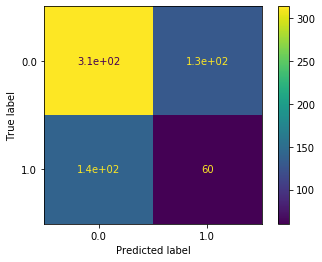

In [10]:
# Dummy Classifier, stratified
dummy_clf_1yr = DummyClassifier(strategy='stratified').fit(x_train_1yr, y_train_1yr)
plot_results(dummy_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='randclf_1yr')

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.6888544891640866


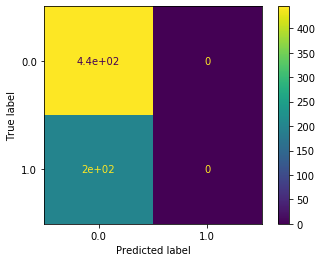

In [11]:
# Dummy Classifier, most frequent
dummy_clf_1yr = DummyClassifier(strategy='most_frequent').fit(x_train_sp, y_train_1yr)
plot_results(dummy_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='randclf_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.61      0.62      0.62       384
         1.0       0.43      0.43      0.43       262

    accuracy                           0.54       646
   macro avg       0.52      0.52      0.52       646
weighted avg       0.54      0.54      0.54       646

Test accuracy: 0.5247678018575851


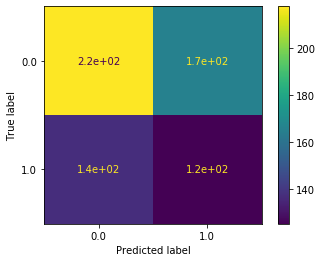

In [12]:
# Dummy Classifier, stratified
dummy_clf_3yr = DummyClassifier(strategy='stratified').fit(x_train_3yr, y_train_3yr)
plot_results(dummy_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='randclf_3yr')

              precision    recall  f1-score   support

         0.0       0.59      1.00      0.75       384
         1.0       0.00      0.00      0.00       262

    accuracy                           0.59       646
   macro avg       0.30      0.50      0.37       646
weighted avg       0.35      0.59      0.44       646

Test accuracy: 0.5944272445820433


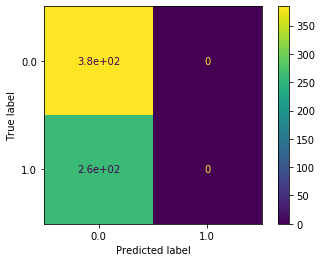

In [13]:
# Dummy Classifier, most frequent
dummy_clf_3yr = DummyClassifier(strategy='most_frequent').fit(x_train_3yr, y_train_3yr)
plot_results(dummy_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='randclf_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.49      0.47      0.48       300
         1.0       0.56      0.57      0.56       346

    accuracy                           0.53       646
   macro avg       0.52      0.52      0.52       646
weighted avg       0.53      0.53      0.53       646

Test accuracy: 0.5294117647058824


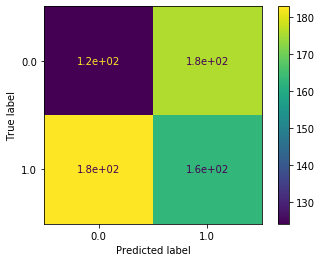

In [14]:
# Dummy Classifier, stratified
dummy_clf_sp = DummyClassifier(strategy='stratified').fit(x_train_sp, y_train_sp)
plot_results(dummy_clf_sp, x_test_sp, y_test_sp,save=True,name='randclf_sp')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       300
         1.0       0.54      1.00      0.70       346

    accuracy                           0.54       646
   macro avg       0.27      0.50      0.35       646
weighted avg       0.29      0.54      0.37       646

Test accuracy: 0.5356037151702786


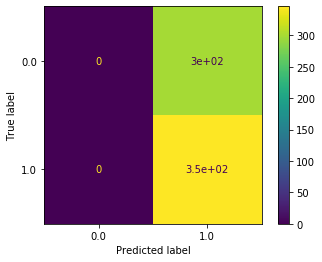

In [15]:
# Dummy Classifier
dummy_clf_sp = DummyClassifier(strategy='most_frequent').fit(x_train_sp, y_train_sp)
plot_results(dummy_clf_sp, x_test_sp, y_test_sp,save=True,name='randclf_sp')

### Logistic Regression with SBERT
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80       445
         1.0       0.47      0.19      0.27       201

    accuracy                           0.68       646
   macro avg       0.59      0.55      0.53       646
weighted avg       0.64      0.68      0.63       646

Test accuracy: 0.6826625386996904


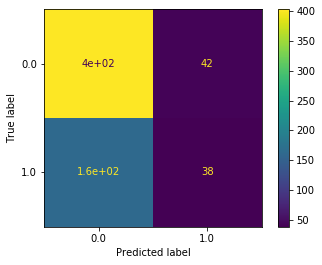

In [16]:
# Logistic regression
logreg_1yr = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_1yr, y_train_1yr)
plot_results(logreg_1yr,x_test_1yr, y_test_1yr,save=True,name='logreg_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.63      0.79      0.70       384
         1.0       0.51      0.32      0.39       262

    accuracy                           0.60       646
   macro avg       0.57      0.55      0.55       646
weighted avg       0.58      0.60      0.57       646

Test accuracy: 0.5975232198142415


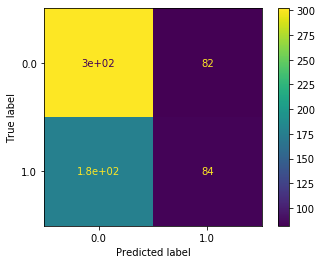

In [17]:
# Logistic regression
logreg_3yr = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_3yr, y_train_3yr)
plot_results(logreg_3yr,x_test_3yr, y_test_3yr,save=True,name='logreg_3yr')

#### S&P 

Confusion matrix:
[[143 157]
 [120 226]]
              precision    recall  f1-score   support

         0.0       0.54      0.48      0.51       300
         1.0       0.59      0.65      0.62       346

    accuracy                           0.57       646
   macro avg       0.57      0.56      0.56       646
weighted avg       0.57      0.57      0.57       646

Test accuracy: 0.5712074303405573


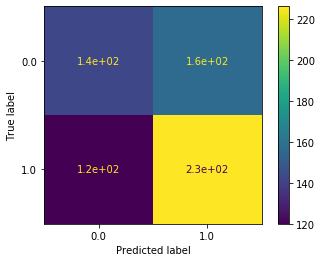

In [20]:
# Logistic regression
logreg_sp = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_sp, y_train_sp)
plot_results(logreg_sp,x_test_sp, y_test_sp,save=True,name='logreg_sp')

### Support Vector Machine with SBERT
#### 1 year rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.6888544891640866


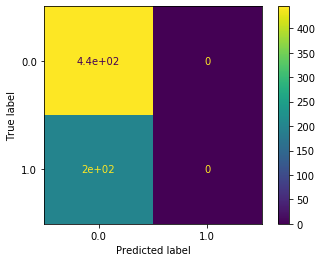

In [18]:
svm_clf_1yr = svm.SVC().fit(x_train_1yr, y_train_1yr)
plot_results(svm_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='svm_1yr')

#### 3 year rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.59      1.00      0.75       384
         1.0       0.00      0.00      0.00       262

    accuracy                           0.59       646
   macro avg       0.30      0.50      0.37       646
weighted avg       0.35      0.59      0.44       646

Test accuracy: 0.5944272445820433


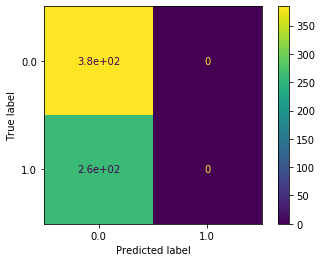

In [22]:
svm_clf_3yr = svm.SVC().fit(x_train_3yr, y_train_3yr)
plot_results(svm_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='svm_3yr')

#### S&P 

              precision    recall  f1-score   support

         0.0       0.56      0.36      0.43       300
         1.0       0.57      0.75      0.65       346

    accuracy                           0.57       646
   macro avg       0.57      0.56      0.54       646
weighted avg       0.57      0.57      0.55       646

Test accuracy: 0.5696594427244582


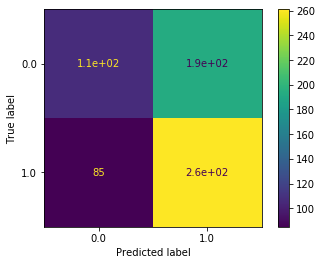

In [23]:
svm_clf_sp = svm.SVC().fit(x_train_sp, y_train_sp)
plot_results(svm_clf_sp, x_test_sp, y_test_sp,save=True,name='svm_sp')

### Random forest with SBERT
#### 1 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.1min finished


Best: 0.576635 using {'max_depth': 100, 'n_estimators': 250}
0.569877 (0.019576) with: {'max_depth': None, 'n_estimators': 250}
0.565324 (0.023185) with: {'max_depth': None, 'n_estimators': 500}
0.561592 (0.009117) with: {'max_depth': None, 'n_estimators': 750}
0.562895 (0.010439) with: {'max_depth': None, 'n_estimators': 1000}
0.570567 (0.014747) with: {'max_depth': 50, 'n_estimators': 250}
0.568136 (0.011918) with: {'max_depth': 50, 'n_estimators': 500}
0.568397 (0.018738) with: {'max_depth': 50, 'n_estimators': 750}
0.564311 (0.014255) with: {'max_depth': 50, 'n_estimators': 1000}
0.576635 (0.021500) with: {'max_depth': 100, 'n_estimators': 250}
0.564544 (0.012779) with: {'max_depth': 100, 'n_estimators': 500}
0.572383 (0.014364) with: {'max_depth': 100, 'n_estimators': 750}
0.564600 (0.013903) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.68      0.96      0.80       445
         1.0       0.11      0.01  

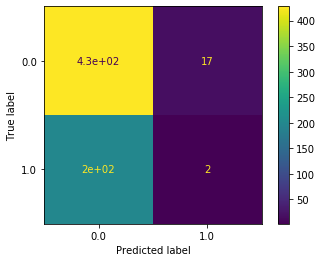

In [24]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_1yr, y_train_1yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_1yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_1yr, y_train_1yr)
plot_results(randomforest_1yr,x_test_1yr, y_test_1yr,save=True,name='rf_1yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### 3 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.2min finished


Best: 0.522374 using {'max_depth': 100, 'n_estimators': 250}
0.504098 (0.030635) with: {'max_depth': None, 'n_estimators': 250}
0.511269 (0.037066) with: {'max_depth': None, 'n_estimators': 500}
0.504723 (0.033683) with: {'max_depth': None, 'n_estimators': 750}
0.505797 (0.027122) with: {'max_depth': None, 'n_estimators': 1000}
0.512588 (0.035102) with: {'max_depth': 50, 'n_estimators': 250}
0.503768 (0.027970) with: {'max_depth': 50, 'n_estimators': 500}
0.512445 (0.037005) with: {'max_depth': 50, 'n_estimators': 750}
0.506655 (0.028022) with: {'max_depth': 50, 'n_estimators': 1000}
0.522374 (0.038030) with: {'max_depth': 100, 'n_estimators': 250}
0.506455 (0.025447) with: {'max_depth': 100, 'n_estimators': 500}
0.509083 (0.020622) with: {'max_depth': 100, 'n_estimators': 750}
0.503622 (0.030095) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.62      0.88      0.72       384
         1.0       0.53      0.20  

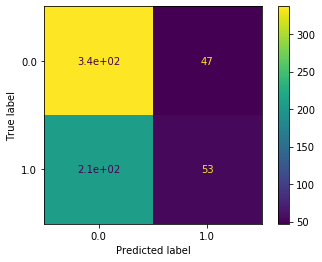

In [25]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_3yr, y_train_3yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_3yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_3yr, y_train_3yr)
plot_results(randomforest_3yr,x_test_3yr, y_test_3yr,save=True,name='rf_3yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### S&P 

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.2min finished


Best: 0.614275 using {'max_depth': None, 'n_estimators': 500}
0.604644 (0.038944) with: {'max_depth': None, 'n_estimators': 250}
0.614275 (0.036677) with: {'max_depth': None, 'n_estimators': 500}
0.608511 (0.051560) with: {'max_depth': None, 'n_estimators': 750}
0.601178 (0.036399) with: {'max_depth': None, 'n_estimators': 1000}
0.599500 (0.046825) with: {'max_depth': 50, 'n_estimators': 250}
0.604672 (0.041962) with: {'max_depth': 50, 'n_estimators': 500}
0.608898 (0.046791) with: {'max_depth': 50, 'n_estimators': 750}
0.607986 (0.038883) with: {'max_depth': 50, 'n_estimators': 1000}
0.591046 (0.037758) with: {'max_depth': 100, 'n_estimators': 250}
0.602834 (0.036036) with: {'max_depth': 100, 'n_estimators': 500}
0.604866 (0.036491) with: {'max_depth': 100, 'n_estimators': 750}
0.607043 (0.043588) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.54      0.43      0.48       300
         1.0       0.58      0.68 

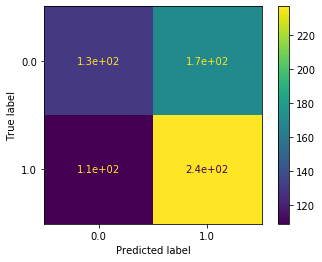

In [26]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_sp, y_train_sp)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_sp = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_sp, y_train_sp)
plot_results(randomforest_sp,x_test_sp, y_test_sp,save=True,name='rf_sp_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

### Neural Network, feed-forward

In [29]:
def create_model(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train_1yr.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train_1yr.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

def randomize_params(params, n):
    test_params = []
    for i in range(n):
        temp_par = {}
        while True: 
            for par in params: 
                temp_par.update({par: np.random.choice(params[par])})
            if temp_par not in test_params: 
                test_params.append(temp_par)
                break
    return test_params

In [30]:
n_tests = 50
# Define possible parameters 
possible_params = dict(batch_size = [8, 16, 32],
                       nodes1 = [50, 100, 250, 500],
                       nodes2 = [0, 50, 100, 250, 500], # 0 implies only one hidden layer 
                       dropout_rate = [0.1, 0.3, 0.5],
                       learning_rate = [1e-3, 1e-4, 1e-5],
                       optimizer = ['RMSprop','Adam'])
test_params = randomize_params(possible_params, n_tests)

#### 1 year rate

In [31]:
historylist_1yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_1yr, y_train_1yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_1yr.append(history)
max_acc_1yr = -1
max_idx_1yr = -1
for i,hist in enumerate(historylist_1yr):
    if max(hist.history['val_acc']) > max_acc_1yr: 
        max_acc_1yr = max(hist.history['val_acc'])
        max_idx_1yr = i
    
print("Best val acc:",max_acc_1yr)
print("For config: ",test_params[max_idx_1yr])


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:11<00:00,  2.64s/it]

Best val acc: 0.75416666
For config:  {'nodes1': 500, 'nodes2': 100, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'RMSprop', 'batch_size': 32}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 1s 1ms/sample - loss: 1.4689 - acc: 0.5760 - val_loss: 0.5739 - val_acc: 0.7500
Epoch 2/100000
960/960 [==============================] - 0s 235us/sample - loss: 0.8519 - acc: 0.5865 - val_loss: 0.5526 - val_acc: 0.7500
Epoch 3/100000
960/960 [==============================] - 0s 242us/sample - loss: 0.8651 - acc: 0.5625 - val_loss: 0.5539 - val_acc: 0.7500
Epoch 4/100000
960/960 [==============================] - 0s 247us/sample - loss: 0.7988 - acc: 0.5938 - val_loss: 0.6753 - val_acc: 0.6167
Epoch 5/100000
960/960 [==============================] - 0s 241us/sample - loss: 0.8385 - acc: 0.6021 - val_loss: 1.0307 - val_acc: 0.2500
Epoch 6/100000
960/960 [==============================] - 0s 242us/sample - loss: 0.8255 - acc: 0.5865 - val_loss: 0.5908 - val_acc: 0.7500
Epoch 7/100000
960/960 [==============================] - 0s 247us/sample - loss: 0.8110 - acc: 0.5969 - val_loss: 0

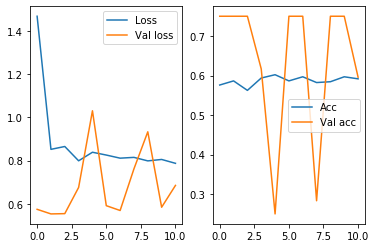

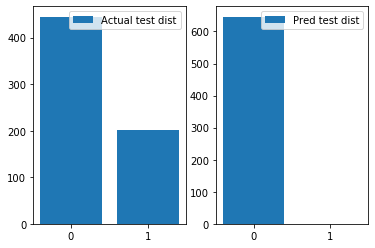

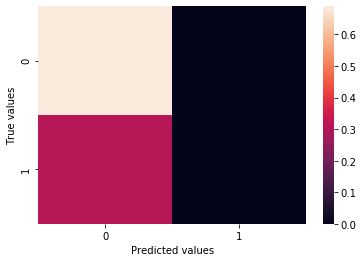

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.689


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
bs = test_params[max_idx_1yr].pop('batch_size')
model_ff_1yr = create_model(**test_params[max_idx_1yr])
test_params[max_idx_1yr].update({'batch_size': bs})

history_1yr = model_ff_1yr.fit(x_train_1yr, y_train_1yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_1yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_1yr]['batch_size'],
                                                          test_params[max_idx_1yr]['nodes1'],
                                                          test_params[max_idx_1yr]['nodes2'],
                                                          test_params[max_idx_1yr]['dropout_rate'],
                                                          test_params[max_idx_1yr]['learning_rate'],
                                                          test_params[max_idx_1yr]['optimizer'])
plot_results_nn(history_1yr,model_ff_1yr,x_test_1yr, y_test_1yr,save=True, name=savename_1yr)

#### 3 year rate

In [33]:
historylist_3yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_3yr, y_train_3yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_3yr.append(history)
max_acc_3yr = -1
max_idx_3yr = -1
for i,hist in enumerate(historylist_3yr):
    if max(hist.history['val_acc']) > max_acc_3yr: 
        max_acc_3yr = max(hist.history['val_acc'])
        max_idx_3yr = i
    
print("Best val acc:",max_acc_3yr)
print("For config: ",test_params[max_idx_3yr])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:32<00:00,  6.65s/it]

Best val acc: 0.6166667
For config:  {'nodes1': 50, 'nodes2': 0, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'optimizer': 'Adam', 'batch_size': 32}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.7150 - acc: 0.5490 - val_loss: 0.6855 - val_acc: 0.5833
Epoch 2/100000
960/960 [==============================] - 0s 172us/sample - loss: 0.6882 - acc: 0.5729 - val_loss: 0.6717 - val_acc: 0.6042
Epoch 3/100000
960/960 [==============================] - 0s 176us/sample - loss: 0.6899 - acc: 0.5813 - val_loss: 0.6675 - val_acc: 0.5917
Epoch 4/100000
960/960 [==============================] - 0s 171us/sample - loss: 0.6736 - acc: 0.5865 - val_loss: 0.6664 - val_acc: 0.6000
Epoch 5/100000
960/960 [==============================] - 0s 186us/sample - loss: 0.6661 - acc: 0.6010 - val_loss: 0.6696 - val_acc: 0.5708
Epoch 6/100000
960/960 [==============================] - 0s 181us/sample - loss: 0.6695 - acc: 0.5938 - val_loss: 0.6918 - val_acc: 0.5583
Epoch 7/100000
960/960 [==============================] - 0s 176us/sample - loss: 0.6477 - acc: 0.6313 - val_loss: 0

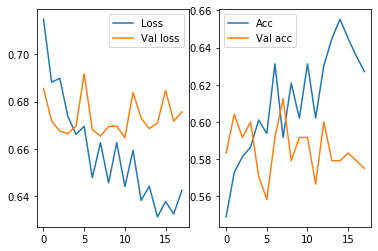

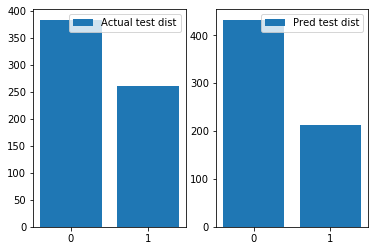

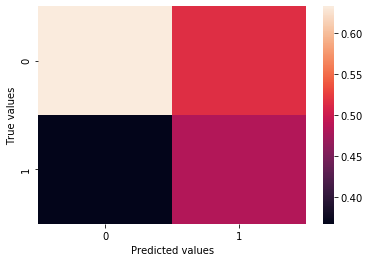

              precision    recall  f1-score   support

         0.0       0.63      0.71      0.67       384
         1.0       0.48      0.39      0.43       262

    accuracy                           0.58       646
   macro avg       0.56      0.55      0.55       646
weighted avg       0.57      0.58      0.57       646

Test accuracy: 0.584


In [34]:
bs = test_params[max_idx_3yr].pop('batch_size')
model_ff_3yr = create_model(**test_params[max_idx_3yr])
test_params[max_idx_3yr].update({'batch_size': bs})

history_3yr = model_ff_3yr.fit(x_train_3yr, y_train_3yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_3yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_3yr]['batch_size'],
                                                          test_params[max_idx_3yr]['nodes1'],
                                                          test_params[max_idx_3yr]['nodes2'],
                                                          test_params[max_idx_3yr]['dropout_rate'],
                                                          test_params[max_idx_3yr]['learning_rate'],
                                                          test_params[max_idx_3yr]['optimizer'])
plot_results_nn(history_3yr,model_ff_3yr,x_test_3yr, y_test_3yr,save=True, name=savename_3yr)


#### S&P

In [35]:
historylist_sp = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_sp, y_train_sp,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_sp.append(history)
max_acc_sp = -1
max_idx_sp = -1
for i,hist in enumerate(historylist_sp):
    if max(hist.history['val_acc']) > max_acc_sp: 
        max_acc_sp = max(hist.history['val_acc'])
        max_idx_sp = i
    
print("Best val acc:",max_acc_sp)
print("For config: ",test_params[max_idx_sp])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:30<00:00, 13.81s/it]

Best val acc: 0.6125
For config:  {'nodes1': 250, 'nodes2': 250, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'optimizer': 'Adam', 'batch_size': 32}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 5s 5ms/sample - loss: 0.7836 - acc: 0.5292 - val_loss: 0.6851 - val_acc: 0.5625
Epoch 2/100000
960/960 [==============================] - 0s 436us/sample - loss: 0.7483 - acc: 0.5531 - val_loss: 0.6814 - val_acc: 0.6000
Epoch 3/100000
960/960 [==============================] - 0s 450us/sample - loss: 0.7266 - acc: 0.5281 - val_loss: 0.6810 - val_acc: 0.5583
Epoch 4/100000
960/960 [==============================] - 0s 466us/sample - loss: 0.7176 - acc: 0.5521 - val_loss: 0.6997 - val_acc: 0.5458
Epoch 5/100000
960/960 [==============================] - 0s 457us/sample - loss: 0.7033 - acc: 0.5542 - val_loss: 0.6936 - val_acc: 0.5333
Epoch 6/100000
960/960 [==============================] - 0s 450us/sample - loss: 0.7073 - acc: 0.5625 - val_loss: 0.6806 - val_acc: 0.5833
Epoch 7/100000
960/960 [==============================] - 0s 434us/sample - loss: 0.6926 - acc: 0.5719 - val_loss: 0

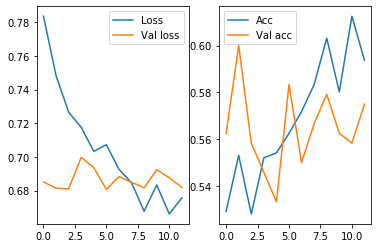

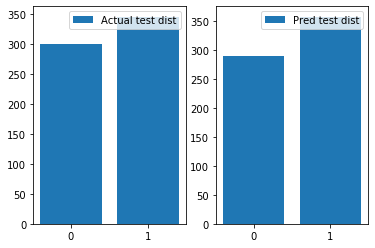

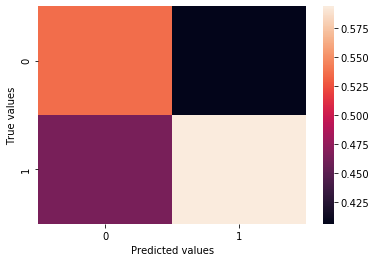

              precision    recall  f1-score   support

         0.0       0.54      0.52      0.53       300
         1.0       0.59      0.61      0.60       346

    accuracy                           0.57       646
   macro avg       0.57      0.56      0.56       646
weighted avg       0.57      0.57      0.57       646

Test accuracy: 0.568


In [36]:
bs = test_params[max_idx_sp].pop('batch_size')
model_ff_sp = create_model(**test_params[max_idx_sp])
test_params[max_idx_sp].update({'batch_size': bs})

history_sp = model_ff_sp.fit(x_train_sp, y_train_sp,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_sp = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_sp]['batch_size'],
                                                          test_params[max_idx_sp]['nodes1'],
                                                          test_params[max_idx_sp]['nodes2'],
                                                          test_params[max_idx_sp]['dropout_rate'],
                                                          test_params[max_idx_sp]['learning_rate'],
                                                          test_params[max_idx_sp]['optimizer'])
plot_results_nn(history_sp,model_ff_sp,x_test_sp, y_test_sp,save=True, name=savename_sp)


## Results

The following results were achieved on the independent test set on the IMDB dataset. The reviews were encoded into 768-dimensional vectors using Sentence-BERT on each sentence in the reviews, and then reduced to one vector per review by taking the elementwise average over each dimension. 

| Model |  Test Accuracy (%)  | Hyperparameters |
| :----- | --------------- | --- | 
| Random Classifier | 50.6 | N/A |
| Logistic Regression | __90.7__  | N/A |
| Linear Discriminant Analysis | 90.3  | N/A |
| Support Vector Machine | 90.0 | N/A |
| Random Forest | 87.1  | n_estimators=5000, max_depth=None |
| XGBoost | 88.9 | n_estimators=500 |
| Multi Layer Perceptron | 89.8 | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |

Logistic Regression currently performs best. The hyperparameter tuning of the neural network-approaches is however not ideal, and would need more time/computational power to optimize further. It should however not be a too large improvement. Looking at the validation accuracy achieved from different configurations of hyperparameters on the neural network, it rarely reaches above 89 %. 

For comparison, the table below displays state-of-the-art models for the IMDB classification task. 

| Model |	Accuracy (%) |	Paper / Source|
|:----- | ---------- | -------------- |  
| XLNet (Yang et al., 2019) |	__96.21__ |	XLNet: Generalized Autoregressive Pretraining for Language Understanding|
| BERT_large+ITPT (Sun et al., 2019) 	|95.79 |	How to Fine-Tune BERT for Text Classification?|
| BERT_base+ITPT (Sun et al., 2019) |	95.63 |	How to Fine-Tune BERT for Text Classification?|
| ULMFiT (Howard and Ruder, 2018) |	95.4 |	Universal Language Model Fine-tuning for Text Classification|
| Block-sparse LSTM (Gray et al., 2017) |	94.99 |	GPU Kernels for Block-Sparse Weights|
| oh-LSTM (Johnson and Zhang, 2016)| 	94.1| 	Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings |
| Virtual adversarial training (Miyato et al., 2016) |	94.1 	|Adversarial Training Methods for Semi-Supervised Text Classification |
| BCN+Char+CoVe (McCann et al., 2017) |	91.8 |	Learned in Translation: Contextualized Word Vectors |
